# Lead Quality Prediction

### Imports

For this task, Pandas is used for data management, NumPy for numerical 
data structures, and Sci-Kit Learn for machine learning algorithms.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

### Read in Data from CSVs

In [80]:
prospect_csv = 'Prospect_FS_DS Assessment.csv'
visitor_activity_csv = 'Visitor_Activity_FS_DS.csv'

prospect_df = pd.read_csv(prospect_csv)
visitor_activity_df = pd.read_csv(visitor_activity_csv)

### Clean Data

In the first step, the datasets are merged. This enables easy access to all features for testing. 

In the following step, the less important features are dropped from the merged dataset- why this is done will be covered later in the hyperparameter tuning step. Also included in this step is converting the lead status feature to a binary variable. As per the project outline, open leads are considered low quality, represented by 0. All other statuses are considered high quality, represented by 1. 

In [81]:
df = prospect_df.merge(visitor_activity_df, on='Prospect_ID', how='inner')
df = df.rename(columns={'Campaign_ID_x':'Prospect_Campaign_ID',
                   'Campaign_ID_y':'Activity_Campaign_ID'})

In [82]:
df.drop(['Score', 'Type','Prospect_ID','ID','Activity_Campaign_ID','Activity_Name', 'Activity_Details'], axis=1, inplace=True)
#df.drop(['Prospect_ID','ID', 'Company','Prospect_Campaign_ID','Source','Job_Title'], axis=1, inplace=True)

status_mapping = {'Open': 0, 'Qualified': 1, 'Contacting': 1, 'Closed': 1}
df['Lead_Status'] = df['Lead_Status'].map(status_mapping)

print(df)

      Prospect_Campaign_ID           Company                   Job_Title  \
0                     2013        Brock Tech  Chief of Digital Marketing   
1                     2013        Brock Tech  Chief of Digital Marketing   
2                     2005       Myxable Co.           Financial Analyst   
3                     2005       Myxable Co.           Financial Analyst   
4                     2009         Polymeris         Procurement Manager   
...                    ...               ...                         ...   
3993                  2013           Bryxham           Financial Analyst   
3994                  2001  Lexinton Rig Inc       Director of Marketing   
3995                  2001  Lexinton Rig Inc       Director of Marketing   
3996                  2005  Lexinton Rig Inc                   President   
3997                  2005  Lexinton Rig Inc                   President   

         Source  Lead_Status  
0       Website            0  
1       Website          

### Prepare Data for Model

The dataset is encoded so the machine learning model can efficiently navigate the data. The features encoded are the company, prospect campaign identifier, source, and job title features. 

The dataset is then split for model training and testing.

In [83]:
df_encoded = pd.get_dummies(df, columns=['Company','Prospect_Campaign_ID','Source','Job_Title'])

# Encode data
X = df_encoded.drop(columns=['Lead_Status'])
y = df_encoded['Lead_Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Hyperparameter Testing

This step implements another algorithm, GridSearch, to determine which hyperparameters are best suited for the machine learning model to efficiently analyze the data. 

NOTE: This step can be time expensive, running for five to ten minutes depending on the computer the user is using this notebook on. The following step includes a hard-coded variable with the results ('params'). 

In [89]:
rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [None, 1, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearch for hyperparameter tuning
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the GridSearch
best_params = grid_search.best_params_

print(best_params) #This statement allows for manual input in the next step to save time

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Train and Test Model

To save on the computational expense of running GridSearch each time, the best parameters from the previous step are stored in the params variable.

The random forest model, rf_model, is created and implemented with the best performing hyperparameters.

In [96]:
params = {                   #These are the best_params from the previous step
    'n_estimators': 100,     #to save on computational expense when rerunning
    'max_depth': None,       #the notebook
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

rf_model = RandomForestClassifier(**params, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

### Accuracy

The accuracy is listed at the bottom, along with other relevant values for calculating accuracy.

'0' is indicative of open, or low value, leads.

'1' is indicative of closed, contacting, or qualified, leads.

Support describes the total number of each type of lead.

F1 Score takes into account precision and recall to determine the accuracy of the model in identifying each of the leads exclusively; the model has 82% accuracy when identifying open leads, and 94% accuracy when identifying high quality leads. 181 of 220 low quality leads accurately identified, and 545 of 580 high quality leads accurately identified.

In [97]:
conf_matrix = confusion_matrix(y_test, y_pred)

class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

feature_importances = rf_model.feature_importances_
feature_names = X.columns

sorted_idx = np.argsort(feature_importances)[::-1]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.82       220
           1       0.91      0.96      0.94       580

    accuracy                           0.91       800
   macro avg       0.90      0.86      0.88       800
weighted avg       0.90      0.91      0.90       800



## Results Visualized

This is a visualization of the above results in a confusion matrix, which shows the number of truly and falsely identified open or closed leads.

Feature importance is the second graph which charts the features in the dataset that are most important for the model in classifying the leads as open or closed.

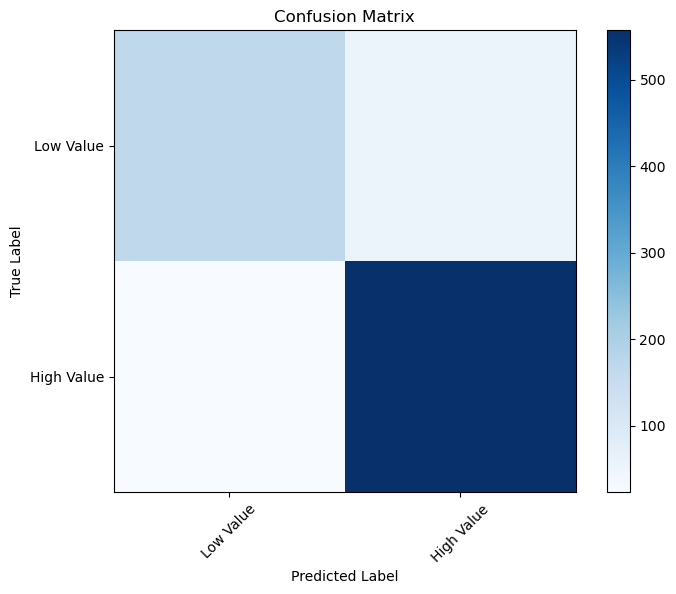

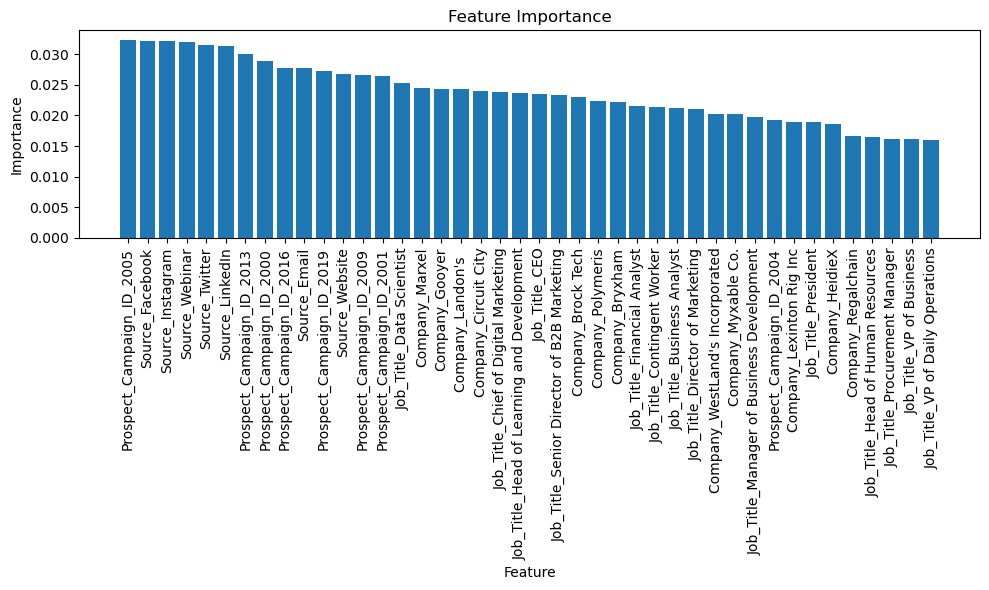

In [98]:
#confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Low Value', 'High Value'], rotation=45)
plt.yticks(tick_marks, ['Low Value', 'High Value'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[sorted_idx])
plt.xticks(range(X.shape[1]), np.array(feature_names)[sorted_idx], rotation=90)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()